### The Impact of Employers Attention to Mental Health of their Employees
In this analysis I will compare self-employment vs hired work type effect on the mental health of the respondents.

The hypothesis I make:

1. Respondents working in the office should have a better mental heath compared to those working remotelly because of socializion and employer care.
2. Employers attention to physical health transforms into better mental health of the employees.

Other goals:

1. Practice SQL quering.
2. Cleaning up the data.
3. Practicing data joins and visualizations.

Let's start from importing all the needed libraries and make necessary settings.

In [185]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

First, I want to see what tables are there in the database.

In [190]:
conn = sqlite3.connect('mental_health.sqlite')
tables=[]
def sql_fetch(conn):
    cur = conn.cursor()
    cur.execute('SELECT name FROM sqlite_master where type = "table"')
    table_name = list(cur.fetchall())
    tables.append(table_name)
sql_fetch(conn)
tables = [item[0] for sublist in tables for item in sublist]
tables

['Answer', 'Question', 'Survey']

I will read all the tables in to data frame individually to review the data they contain.

In [113]:
table_dict={}
for table in tables:
    table_dict[table] = pd.read_sql(f'SELECT * from {table}', conn)
for key in table_dict:
    globals()[key] = table_dict[key].copy()
Answer.head()

,AnswerText,SurveyID,UserID,QuestionID
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117
236897,Other,2016,2693,117


In [186]:
Question.head()

,questiontext,questionid,numbered
0,What is your age?,1,1. What is your age?
1,What is your gender?,2,2. What is your gender?
2,What country do you live in?,3,3. What country do you live in?
3,"If you live in the United States, which state ...",4,"4. If you live in the United States, which sta..."
4,Are you self-employed?,5,5. Are you self-employed?


I will be selecting the questions that would help me answer the raised quesions. Thus I want to number those questions for the easier readability.

In [114]:
Question['numbered'] = Question['questionid'].astype(str)+ ". " +Question['questiontext']
Question.head()

,questiontext,questionid,numbered
0,What is your age?,1,1. What is your age?
1,What is your gender?,2,2. What is your gender?
2,What country do you live in?,3,3. What country do you live in?
3,"If you live in the United States, which state ...",4,"4. If you live in the United States, which sta..."
4,Are you self-employed?,5,5. Are you self-employed?


In [115]:
Survey

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


From initial data review I see that i do not need to use survey table at all because the names of the surveys are the same except for the year of the survey. 

I will review question table in detail now to see what kind of questions were asked. This will help me group the respondends based on some of the answers.

In [116]:
for q in Question['numbered']:
    print(q)

1. What is your age?
2. What is your gender?
3. What country do you live in?
4. If you live in the United States, which state or territory do you live in?
5. Are you self-employed?
6. Do you have a family history of mental illness?
7. Have you ever sought treatment for a mental health disorder from a mental health professional?
8. How many employees does your company or organization have?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
13. Is your primary role within your company related to tech/IT?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental hea

In [188]:
# Calculating the number of unique users
users = Answer['UserID'].nunique()
users

4218

One of the first things I want to do is to define the respondents profile. For that, I will query the data Answer table with the selected questions that help define the participant.
There were at least 7 questions that relate to description of the participant. I will generate the table with these responces and prepare it for further analysis. 
Among the questions there are two that help define the participant in terms of race and role at work. However, due to huge amount of missing responce on the race and undefined meaning of the role responces, I chose to eliminate them from the analysis.

In [118]:
#query
persons = '''SELECT * from Answer WHERE QuestionID IN(1,2,3,5,50,93,118)'''
df_persons = pd.read_sql_query(persons, conn)
df_persons = df_persons.pivot(index=(['SurveyID','UserID']), columns='QuestionID', values='AnswerText')
df_persons.columns = ['age','sex','living_country','employment_type',
                        'working_country', 'remote', 'remote2']

#unifying country name
df_persons['living_country'] = df_persons['living_country'].replace({'United States':'US',
                                                                         'United States of America':'US'})
df_persons['working_country'] = df_persons['working_country'].replace({'United States':'US',
                                                                         'United States of America':'US'})
#grouping gender to three categories
df_persons['sex'] = df_persons['sex'].str.lower()
df_persons.loc[(df_persons['sex']!='male')&(df_persons['sex']!='female'), 'sex']='other'

#adding age groups 0-10, 11-20, etc.
#some of the ages provided were a joke e.g. '-1' or '329'. I replced those with the mean of all age.
df_persons['age'] = df_persons['age'].astype(int)
age_mask = (df_persons['age']<0)|(df_persons['age']>99)
age_mean =  df_persons.loc[~age_mask, 'age'].mean()
df_persons.loc[age_mask,'age'] = age_mean
bins = [0,18,30,40,50,60,70,100]
age_groups = ['0-18', '18-29','30-39','41-50','51-60','61-70','71+']
df_persons['age_groups']=pd.cut(df_persons.age, bins, labels=age_groups, include_lowest = True)

#if working country is Nan, I make an asumption that living country is equal to working.
df_persons.working_country.fillna(df_persons.living_country, inplace=True)

#providing categories for employment type
df_persons['employment_type'] = df_persons['employment_type'].astype(int)
types = {1:'Self-employed',0:'Hired', -1:'NA'}
df_persons['employment_type'].replace(types, inplace=True)

'''there are two questions related to remote work. One asks if a person works at least 50% of the time 
remotely, the other asks in general about the remote work. Those questions were asked in the 
different surveys and their response do not overlap. I will join these columns and unify their answers to 
yes and no'''

df_persons['remote2'] = df_persons['remote2'].replace(['Always', 'Never','Sometimes'],
                                                          ['Yes', 'No','Yes'])
df_persons.remote.fillna(df_persons.remote2, inplace=True)
df_persons.remote.fillna('NA', inplace=True)
del df_persons['remote2']
df_persons.reset_index(inplace=True)
df_persons.count()

SurveyID           4218
UserID             4218
age                4218
sex                4218
living_country     4218
employment_type    4218
working_country    4218
remote             4218
age_groups         4218
dtype: int64

Next, I will create a table with the responces that help define mental healt state of the participants.

In [119]:
health_state = '''SELECT * from Answer WHERE QuestionID IN(32,33,34)'''
health_state = pd.read_sql_query(health_state, conn)
health_state = health_state.pivot(index=(['SurveyID','UserID']), columns='QuestionID', values='AnswerText')
health_state.columns = ['past_disorder','present_disorder','ever_disorder']
health_state = health_state.replace(['-1'],['NA'])
health_state = health_state.replace(['Possibly'],['Maybe'])
health_state.reset_index(inplace=True)
health_state.head()

,SurveyID,UserID,past_disorder,present_disorder,ever_disorder
0,2016,1261,Yes,No,Yes
1,2016,1262,Yes,Yes,Yes
2,2016,1263,Maybe,No,No
3,2016,1264,Yes,Yes,Yes
4,2016,1265,Yes,Yes,Yes


Finaly, I will create a table to sumarise the support that employers provide for their employees.

In [191]:
employer_care = '''SELECT * from Answer WHERE QuestionID IN(10,23,64,65,76,77,91,94,96,111)'''
employer_care = pd.read_sql_query(employer_care, conn)
employer_care = employer_care.pivot(index=(['SurveyID','UserID']), columns='QuestionID', values='AnswerText')
employer_care.columns = ['present_benefits','past_benefits','physical_care','mental_care', 'past_physical_care', 
                         'past_mental_care', 'mental_as_physical','options','resources_provided',
                         'past_mental_as_physical']
employer_care = employer_care.replace(['No, none did', 
                                       'Yes, they all did','Some did', "I don't know", 'None did', '-1'],
                                      ['No', 'Yes','Some',"Don't know", 'No','NA'])
employer_care.groupby('past_benefits').count()

,present_benefits,physical_care,mental_care,past_physical_care,past_mental_care,mental_as_physical,options,resources_provided,past_mental_as_physical
past_benefits,,,,,,,,,
Don't know,619,306,306,306,306,313,0,0,313
NA,368,199,199,199,199,169,0,0,169
No,700,328,328,328,328,372,0,0,372
Some,852,461,461,461,461,391,0,0,391
Yes,419,231,231,231,231,188,0,0,188


### Exploratory analysis

First, I want to analyse the people that took part in the survey. I will answer the questions:
1. Where are they from and where do they work.
2. What is their demographic distribution.
3. How do they work - remote or office.

In [121]:
coordinates = pd.read_csv('longitudes.csv') 
# I have added additional file with the geographical data of countries
lived_countries = df_persons.groupby('living_country').size()
countries_count = lived_countries.count()
lived_countries = lived_countries.to_frame('Count').reset_index().sort_values('Count',
                                                                                          ascending=False)
print(f'There are {countries_count} countries represented in the survey throught the period of 5 years')
lived_countries.rename(columns = {'living_country':'name'}, inplace=True)
lived_countries = pd.merge(coordinates, lived_countries, on='name', how='inner')

There are 80 countries represented in the survey throught the period of 5 years


In [122]:
fig = px.scatter_mapbox(lived_countries, lat='latitude', lon='longitude', color='name',
                        size='Count',  
                        hover_data={'latitude':False, 'longitude': False, 'name':True,
                                    'Count':True},
                        zoom=1, mapbox_style='carto-positron') 
fig.update_layout(width=1200, height=600)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.show()

US is mostly represented country in the surwey with the 2604 representatives.

Now, lets see the gender and age distribution of the participats.

In [123]:
age_groups = df_persons.groupby(['age_groups','sex']).size()
age_groups = age_groups.to_frame('Count').reset_index()

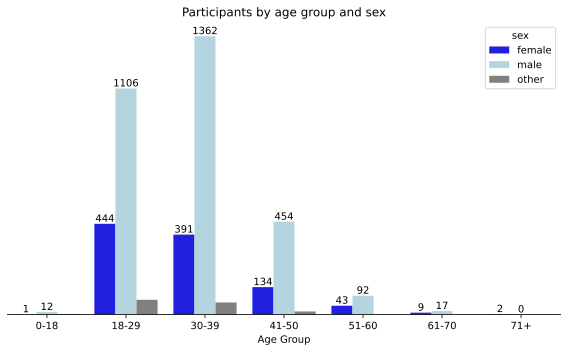

In [194]:
fig, ax = plt.subplots(figsize=(8,5))
colors=['blue','lightblue', 'grey']
sns.barplot(x ='age_groups', y='Count', hue='sex', data=age_groups, palette = colors)
plt.xlabel('Age Group')
ax.bar_label(ax.containers[0])    # barlabels
ax.bar_label(ax.containers[1])
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, left=True, bottom=False)
ax.set_title('Participants by age group and sex')
plt.show()

The most represented group of representatives are male in their 30s. 

Another interesting tendency is the decreasing number of female participants. This is likely due to the motherhood.

Now, let's see respondents are distributed byt wokring type - remote or office. 

In [195]:
# Creating new dataframe for the graphical analysis
work_type = df_persons.groupby(['remote','employment_type']).size()
work_type = work_type.to_frame('Count').reset_index()
work_type = work_type[(work_type['employment_type']!='NA')&(work_type['remote']!='NA')]
work_type

,remote,employment_type,Count
2,No,Hired,1146
4,No,Self-employed,59
5,Yes,Hired,1096
7,Yes,Self-employed,374


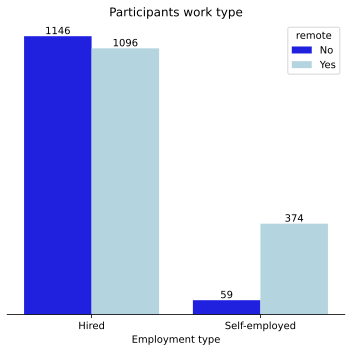

In [127]:
fig, ax = plt.subplots(figsize=(5,5))
colors=['blue','lightblue']
sns.barplot(x ='employment_type', y='Count', hue='remote', data=work_type, palette = colors)
plt.xlabel('Employment type')
ax.bar_label(ax.containers[0])    # barlabels
ax.bar_label(ax.containers[1])
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, left=True, bottom=False)
ax.set_title('Participants work type')
plt.show()

Interesting discovery that in IT sector respondents that are hired and work remotely almost 50% of the time.

Now, after we have a better understanding of the group of people that we are dealing with, lets look at how they perceive their mental health.

In [129]:
#i have merged two dataframes. Inner join eliminated those respondents that failed to answer the questions
persons_state = pd.merge(health_state, df_persons, on='UserID', how='inner')

past_grouped = persons_state.groupby('past_disorder').size()
past_grouped = past_grouped.to_frame('Count').reset_index()
past_grouped = past_grouped[(past_grouped['past_disorder']!='NA')]
past_grouped['%'] = (past_grouped['Count']/past_grouped['Count'].sum()*100).round(0)

present_grouped = persons_state.groupby('present_disorder').size()
present_grouped = present_grouped.to_frame('Count').reset_index()
present_grouped = present_grouped[(present_grouped['present_disorder']!='NA')]
present_grouped['%'] = (present_grouped['Count']/present_grouped['Count'].sum()*100).round(0)

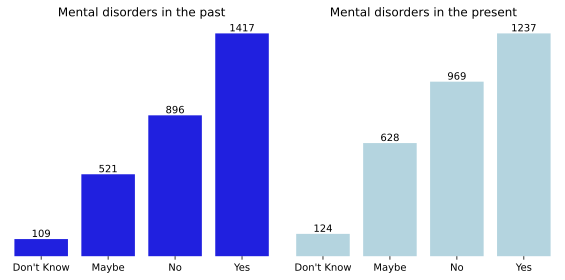

In [130]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.autolayout'] = True
fig, ax = plt.subplots(1,2)
sns.barplot(x='past_disorder', y='Count', data=past_grouped, color='blue', errorbar=None, ax=ax[0])
sns.barplot(x='present_disorder', y='Count',  data=present_grouped, color='lightblue', errorbar=None,ax=ax[1])
ax[0].title.set_text('Mental disorders in the past')
ax[1].title.set_text('Mental disorders in the present')
ax[0].axes.get_yaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)
sns.despine(top=True, left=True, bottom=True)
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)
for i in ax[0].containers:
    ax[0].bar_label(i,)
for j in ax[1].containers:
    ax[1].bar_label(j,)
plt.show()

In [131]:
past_yes = past_grouped[past_grouped['past_disorder']=='Yes']
x=past_yes['%'].iloc[0]
present_yes = present_grouped[present_grouped['present_disorder']=='Yes']
y=present_yes['%'].iloc[0]
print(f'There are {x}% of respondents in the past have experienced mental disorders and {y}% \
those who presently have it.')

There are 48.0% of respondents in the past have experienced mental disorders and 42.0% those who presently have it.


Out of those who dared to provide responce to the question about their past and present mental health, 48 and 42 % respectively responded positively. This is quite shocking number. 

I will focus now on those who have indicated that they have or have had mental disorders. I will try answering the following questions:
1. The number of respondents who have had disorders in the past and still have it in the present. 
2. The percentage of people that have or have had mental disorders and are hired or self-employed.
3. Demographic composition of those people.

In [132]:
yes_group = persons_state[(persons_state['past_disorder']=="Yes") | 
                          (persons_state['present_disorder']=="Yes")]
continuous_disorder = persons_state[(persons_state['past_disorder']=="Yes") & 
                          (persons_state['present_disorder']=="Yes")]
disordered =  ((continuous_disorder['UserID'].count() / yes_group['UserID'].count())*100).round(0)
#continuous_disorder.head()
print(f'Respondents that condinue to have mental disorders make {disordered}% of those that \
responded positively initially, which make 35.0% that have solved their mental issues.')

Respondents that condinue to have mental disorders make 65.0% of those that responded positively initially, which make 35.0% that have solved their mental issues.


In [196]:
work_type_grouped = work_type.groupby('employment_type')['Count'].sum()
work_type_grouped = work_type_grouped.to_frame('total_by_type').reset_index()
counts = yes_group.groupby('employment_type', 
                           group_keys=False)[['past_disorder',
                                              'present_disorder']].apply(lambda x: 
                                                                         (x == 'Yes').astype(int).sum())
counts.columns = ['past_yes', 'present_yes']
counts.reset_index(inplace=True)
change = pd.merge(counts, work_type_grouped, on='employment_type')
change['past_yes_percent'] = (change['past_yes'] / change['total_by_type'] * 100).round(0)
change['present_yes_percent'] = (change['present_yes'] / change['total_by_type'] * 100).round(0)
change_percent = change.loc[:,['employment_type','past_yes_percent','present_yes_percent']]
change_percent = change_percent.melt(id_vars='employment_type')
change_percent['variable'] = change_percent['variable'].replace({'past_yes_percent':'Past',
                                                                         'present_yes_percent':'Present'})

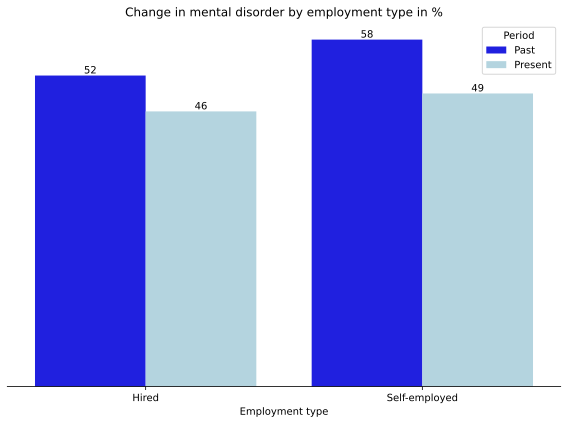

In [134]:
fig, ax = plt.subplots(figsize=(8,6))
colors=['blue','lightblue']
sns.barplot(x ='employment_type', y='value', hue='variable', 
            data=change_percent, palette = colors)
plt.xlabel('Employment type')
ax.bar_label(ax.containers[0])    # barlabels
ax.bar_label(ax.containers[1])
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, left=True, bottom=False)
ax.set_title('Change in mental disorder by employment type in %')
plt.legend(title='Period', loc='upper right')
plt.show()

As asumed, the number of people with mental disorders in the past and in the present, are higher among the self employed. The reasons can be multiple. One of the assumptions is that hired people may have employers, who take care of their mental health matters, while self-empployed have to take care of themselves. We will check this assumption. Before that, I want to analyse the "Yes" group in terms of demographics - country, sex, and age group.

In [136]:
yes_by_country = yes_group.groupby('living_country', 
                           group_keys=False)[['past_disorder',
                                              'present_disorder']].apply(lambda x: 
                                                                         (x == 'Yes').astype(int).sum())
yes_by_country.columns = ['past_yes', 'present_yes']
yes_by_country.reset_index(inplace=True)
yes_by_country.sort_values('past_yes', ascending=False, inplace=True)
yes_by_country['diff'] = yes_by_country['past_yes'] - yes_by_country['present_yes']
yes_by_country['diff%'] = ((yes_by_country['diff']/ yes_by_country['past_yes'])*100).round(0)

#pick the countries with the largest number of 'yes' people
yes_by_country = yes_by_country[yes_by_country['past_yes']>4]
yes_by_country

,living_country,past_yes,present_yes,diff,diff%
48,US,1001,909,92,9.0
49,United Kingdom,135,103,32,24.0
9,Canada,52,47,5,10.0
19,Germany,36,18,18,50.0
3,Australia,30,25,5,17.0
32,Netherlands,28,28,0,0.0
46,Switzerland,13,9,4,31.0
7,Brazil,12,12,0,0.0
26,Ireland,10,8,2,20.0
18,France,9,5,4,44.0


In [137]:
yes_by_sex = yes_group.groupby('sex', 
                           group_keys=False)[['past_disorder',
                                              'present_disorder']].apply(lambda x: 
                                                                         (x == 'Yes').astype(int).sum())
yes_by_sex.columns = ['past_yes', 'present_yes']
yes_by_sex.reset_index(inplace=True)
yes_by_sex.sort_values('past_yes', ascending=False, inplace=True)
yes_by_sex['diff'] = yes_by_sex['past_yes'] - yes_by_sex['present_yes']
yes_by_sex['diff%'] = ((yes_by_sex['diff']/ yes_by_sex['past_yes'])*100).round(0)
yes_by_sex

,sex,past_yes,present_yes,diff,diff%
1,male,864,735,129,15.0
0,female,469,424,45,10.0
2,other,84,78,6,7.0


In [138]:
yes_by_age = yes_group.groupby('age_groups', 
                           group_keys=False)[['past_disorder',
                                              'present_disorder']].apply(lambda x: 
                                                                         (x == 'Yes').astype(int).sum())
yes_by_age.columns = ['past_yes', 'present_yes']
yes_by_age.reset_index(inplace=True)
yes_by_age.sort_values('past_yes', ascending=False, inplace=True)
yes_by_age['diff'] = yes_by_age['past_yes'] - yes_by_age['present_yes']
yes_by_age['diff%'] = ((yes_by_age['diff']/ yes_by_age['past_yes'])*100).round(0)
yes_by_age

,age_groups,past_yes,present_yes,diff,diff%
2,30-39,601,536,65,11.0
1,18-29,497,458,39,8.0
3,41-50,239,184,55,23.0
4,51-60,61,44,17,28.0
5,61-70,17,14,3,18.0
0,0-18,1,0,1,100.0
6,71+,1,1,0,0.0


Demographic analysis revealed that best mental state improvement happened in - Germany - by 50%. Males tend to have a better mental state improvement. Finally, respondents in the 40% and 50% also show the highest rate of mental healt improvement. 

As we have come across the number of discoveries about who is more prone for mental disorders and who is better at recovering, let's now analize if employers attention to their employess mental health had anything to do with their mental state and their mental state changes over time.

To make this analysis more efficient, I will chose those participants that have improved over time and analize what has affected this change.

First, I will filter those respondents that have had mental disorders in the past. Then, I will merge this group with the employers care table. After I will analize the patter of employer attitude and behavior towards their employees and the effect on it on their recovery. 

In [139]:
persons_short =  persons_state.loc[:,['UserID','employment_type','past_disorder',
                                      'present_disorder','sex','age_groups', 'living_country']]
past_disordered = persons_short[persons_short['past_disorder']=="Yes"]
recovered = past_disordered[past_disordered['present_disorder']=="No"]
pool = past_disordered['UserID'].count()
r_pool = recovered['UserID'].count()
print(f'Pool of paricipants, who have had mental disorders in the past are {pool}, which is \
{pool/users*100:.0f} % of total number of participants')
print(f'Pool of paricipants, who have recovered from mental disorder in the past are {r_pool}, which is \
{r_pool/users*100:.0f} % of total number of participants and {r_pool/pool*100:.0f} % of disordered in \
the past.')

Pool of paricipants, who have had mental disorders in the past are 1417, which is 34 % of total number of participants
Pool of paricipants, who have recovered from mental disorder in the past are 158, which is 4 % of total number of participants and 11 % of disordered in the past.


In [197]:
pool_care = pd.merge(past_disordered, employer_care, on='UserID', how='inner')
graded_responces = pool_care.loc[:,['UserID','employment_type','past_disorder',
                                      'present_disorder','sex','age_groups', 'living_country',
                                   'physical_care','mental_care','past_mental_care','past_physical_care']]
graded_columns = ['past_physical_care','physical_care','past_mental_care','mental_care']

#converting reponses to integers
for i in graded_columns:
    graded_responces[i].replace({'NA':'0'}, inplace=True)
    graded_responces[i].fillna('0', inplace=True)
    graded_responces[i] = graded_responces[i].astype(int)
graded_responces[graded_columns] = graded_responces[graded_columns].apply(pd.to_numeric, errors='coerce')

#filterint out the responses that are less than 1 and crea
yes_no = pool_care.loc[:,['UserID','employment_type','past_disorder','present_disorder','sex',
                          'age_groups', 'living_country','present_benefits','past_benefits',
                          'mental_as_physical','past_mental_as_physical']]

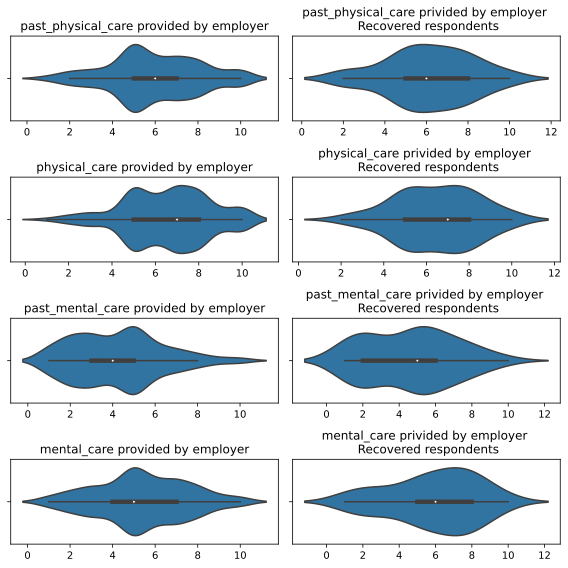

In [141]:
fig, ax = plt.subplots(4,2, figsize=(8,8))
for i, col in enumerate(graded_columns):
    sns.violinplot(x=col, data=graded_responces[graded_responces[col] > 0], ax=ax[i,0])
    ax[i,0].set_title(col+ ' provided by employer')
    ax[i, 0].set(xlabel='')
    sns.violinplot(x=col, data=graded_responces[(graded_responces[col] > 0)
                                                        &(graded_responces['present_disorder'] == 'No')],
    ax=ax[i,1])
    ax[i, 1].set(xlabel='')
    ax[i,1].set_title(col+ ' privided by employer \n Recovered respondents')
plt.tight_layout()
plt.show()

Graphic analysis shows that those employees that have provided mental care in the past or are providing today, have a higher rate of recovered employees. Also the graph shows that phisical care does not affect the recovery significantly - the means of both categories are very similar.

Next, let's see how categorical resonces are represented. For the sake of clarity, I will analize only 'yes' and 'no' answers.

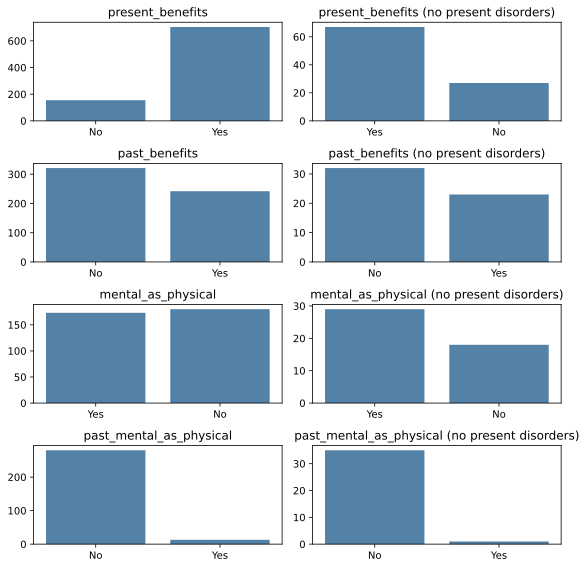

In [184]:
cat_columns = ['present_benefits','past_benefits','mental_as_physical','past_mental_as_physical']
fig, ax = plt.subplots(ncols=2, nrows=len(cat_columns), figsize=(8,8))
for i, col in enumerate(cat_columns):
    sns.countplot(x=col, data=yes_no[(yes_no[col] == 'Yes') | (yes_no[col] == 'No')], 
                  color='#4682B4', ax=ax[i,0])
    ax[i,0].set_title(col)
    ax[i,0].set(xlabel='')
    ax[i,0].set(ylabel='')
    sns.countplot(x=col, data=yes_no[(yes_no['present_disorder']=='No') & 
                                     ((yes_no[col] == 'Yes') | (yes_no[col] == 'No'))],
                  color='#4682B4', ax=ax[i,1])
    ax[i,1].set_title(col+ ' (no present disorders)')
    ax[i,1].set(xlabel='')
    ax[i,1].set(ylabel='')
plt.show()

The graphs, especialy the one where employers take mental care as seriously as phisical have possibly affected the recovery of the employees. We also see that health benefits in the past and in the present have also affected the recovery since. 


In [198]:
conn.close()

### Conclusiuons

1. I have raised the hypothesis that respondents working in the office should have a better mental heath compared to those working remotelly because of socializion and employer care. This hypothesis proved to be true since respondents that were hired has less mental disorders proportionally - although not significantly less.
2. Second hypothesis suggested that employers attention to physical health transforms into better mental health of the employees. We could see that those employees that have recovered from their mental disorders claimed that their employees provide mental care. Escecially, mental care is needed in the present. 

Some other findings:

1. Almost 50% of IT sector employees experience or have experienced in the past some mental disorders.
2. Those that are self-employed are in the higher risk group to have mental disorders.
3. German employers seems to care for their employees better than most other countries - since their recovery rate was the best.
4. Attention to mental disorder issues helps.

The survey data is very rich and there are much more analysis that can be done based on the provided data. 

